# Project 3 : NumPy, matplotlib, and Python functions

## Instructions

### Description

Below is a guided exercise in doing linear regression using a gradient descent algorithm.  The goal here isn't to teach you the gradient descent algorithm, or scientific computing in general, but to give you experience with using NumPy for matrix-vector math, matplotlib for simple visualizations, and more Python (specifically, writing functions).

### Grading

For grading purposes, we will clear all outputs from all your cells and then run them all from the top.  Please test your notebook in the same fashion before turning it in.

### Submitting Your Solution

To submit your notebook, first clear all the cells (this won't matter too much this time, but for larger data sets in the future, it will make the file smaller).  Then use the File->Download As->Notebook to obtain the notebook file.  Finally, submit the notebook file on Canvas.


## Setup Code

Feel free to look through this and see what it is doing, but basically it is just setting up a synthetic regression problem for you, very much like we did in class.  Just make sure you execute the cell before going on to the problems!  If you wish to see the training and testing points, uncomment the last two lines in the cell.

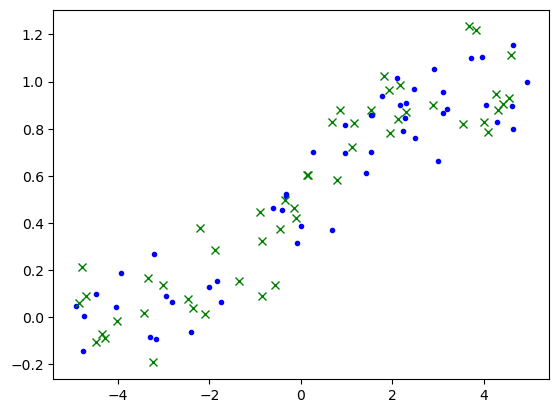

In [1]:
#generate and set up data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def f(X):
    return 1/(1 + np.exp(-X))

n = 50
np.random.seed(12345)
trainX = np.random.random(n) * 10 - 5
trainY = f(trainX) + np.random.randn(n) * 0.125
testX = np.random.random(n) * 10 - 5
testY = f(testX) + np.random.randn(n) * 0.125
plt.plot(trainX, trainY, 'b.', testX, testY, 'gx')
plt.show()

#### Problem 1: Features (10 points)
For this problem, you need to create a Python function named `phi` that will produce a set of between 5 and 8 features for a given X input, such as the trainX vector created above.  This is basically what we did in lectures 5-7 to generate our design matrix $\Phi$.  The difference is that in our lectures we used powers of $x$ exclusively, where as below I would like you to use at least two non-polynomial functions of $x$.  You can use any functions you want; consider trigonometric functions, logarithmic and exponential functions, radial basis function (Gaussians), etc.  The only functions you are forbidden to use are functions generating a sigmoid such as the one generating the synthetic data for this problem (this includes the arctangent function)!  It is recommended, but not required, that one of your features is an intercept term (all 1's).

Note the triple-quoted string at the top of the function - this produces a documentation comment for the function (visible when you do help(function) or function?).  You should get in the habit of making these for your code.

Note: We discussed a variation of this in the `06-ml-beginnings lecture` ... your code will just have to create a list containing different functions of x to send into the np.array() instead of using all powers of x like we did for trainX in the example: `Phi = np.array([trainX ** p for p in range(6)]).T`

In [2]:
#define the test matrix

def phi(X):
    '''
    Return a design matrix (a NumPy ndarray) whose columns are functions of the input vector, X.
    
    Produce a set of between 5 and 8 features for a given X input, one of which is an intercept term (all 1's)
    
    X (numpy.ndarray) input vector returns numpy.ndarray feature vector
    '''
    #Create a np array X
    X= np.asarray(X)
    #create an array to store features
    features = []
    #make a column of 1's for intercept term
    features.append(np.ones(X.shape[0]))
    #add original features
    features.append(X)
    
    '''
    
    Add polynomial or non-polynomial features with features.append(np.'feature equation here'(X))
    
    For the range(2,poly) equates to (# features) = (poly value); so at poly = 4 we have 4 features, we need to add
    a minimum of 2 non-polys... for a total of 6 features. We can add up to 4 non-poly features
    
    Use at least two non-polynomial functions of 𝑥. You can use any functions you want; consider trigonometric functions, 
    logarithmic and exponential functions,  radial basis function (Gaussians), etc. The only functions you are forbidden 
    to use are functions generating a sigmoid such as the one generating the synthetic data for this problem 
    (this includes the arctangent function)!
    
    '''
    # Add polynomial features, I interpreted the instructions as we COULD used polynomials, just had to use 2 non as well
    
    #used this to play around with how high the polynomial can go without producing NA's
    poly = 4
    
    for i in range(2, poly):
        features.append(X ** i)
    
    # Add non-polynomial features NO SIGMOIDs, played with different ones to see how it changed the fit
    
#     features.append(np.abs(X)) #abs value
#     features.append(np.sqrt(np.abs(X))) #sqr rt of abs value

#     features.append(np.exp(X))

    features.append(np.sin(X))
    features.append(np.cos(X))
    
#after testing the above, mixing and matching, I found the poly's + sin and cos features seemed to give a good 
#enough fit. Adding the other features did not seem to greatly improve RMSE of the training or test
    
    # Stack the features to create the feature matrix
    feature_matrix = np.column_stack(features)
    
    return feature_matrix

You should probably check the output of phi(trainX) below, just to make sure none of your functions generated NaNs (Not a Number values) or infs (infinities) - these can result, e.g, from taking the log of a negative number or division by a number close to zero.

In [3]:
#calls your newly created phi function above for testing
Phi_train = phi(trainX)
Phi_test = phi(testX)

# Print the shape of the Train and Test matrices... verifying what I did above worked
# shape should be (n, # of features)
print("Train Design Matrix Shape:", Phi_train.shape)
print("Test Design Matrix Shape:", Phi_test.shape)

#Phi_train #view phi(trainX) to make sure no NaNs or infs; comment out to not view the results

Train Design Matrix Shape: (50, 6)
Test Design Matrix Shape: (50, 6)


#### Problem 2: Gradient Descent (20 points)
The basic idea behind [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is that you can minimize a parametrized function by simply taking small steps in the negative direction of the derivative of the function.  I'm not going to go into too many details here, since [Wikipedia's article](https://en.wikipedia.org/wiki/Gradient_descent) does such a good job.  Also see [Andrew Ng's class notes](https://datajobs.com/data-science-repo/Generalized-Linear-Models-[Andrew-Ng].pdf) on the topic for a more thorough mathematical treatment.

In our cases, we are interesting in minimizing the square error in our linear approximation with respect to our training data.  That is, we want to minimize
$$ \begin{align}
     & \sum_{i=0}^n (\hat{f}(x_i) - y_i)^2 \\
   = & \sum_{i=0}^n (\phi_0(x_i) w_0 + \phi_1(x_i) w_1 + \dots + \phi_k(x_i) w_k - y_i)^2 \\ 
   = & \|\Phi w - \textbf{y}\|^2 
   \end{align}
$$

Since all of our training data (the $x_i$ and $y_i$ terms) are known, the only variables we can optimize on are the $w$ variables. The gradient is (skipping over a *lot* of linear algebra):

$$ \begin{align}
       & \nabla \|\Phi w - \textbf{y}\|^2  \\
     = & \Phi^T (\Phi w - \textbf{y})
   \end{align}
$$

The gradient descent algorithm asks us, then, to start with some guess for $\textbf{w}$ and repeatedly subtract some small multiple of the gradient from it, until $\textbf{w}$ converges:

$$ \textbf{w} = \textbf{w} + \alpha \Phi^T (\textbf{y} - \Phi \textbf{w}) $$

Convergence is a somewhat tricky issue, and the step size $\alpha$ is a key to getting good convergence; a large $\alpha$ speeds up the algorithm, but can miss the optimum by stepping too far (and can even diverge); a small $\alpha$ may result in a better optimum, but at the cost of speed.  You may have to play around a bit with different values for $\alpha$ until you get a good result; print out the norm of the change in `w` at each step to see if you are converging or diverging, or put in an `if` statement to kill the function when the norm starts growing large.  In testing this assignment, I found I had to use a pretty small $\alpha$ to prevent divergence; 0.00001 worked for me.  However, you will get different results depending on your features.

So, you will write a function `lr` which takes in $\Phi$ (generated by your `phi` function above applied to `trainX`) and $y$ (`trainY`) and returns a vector `w` computed by gradient descent.  Follow the steps below to compute w:

 1. Start with `w` as the zero vector.
 2. Initialize `norm`, `delta`, and step counter.
 3. Calculate `delta` (The amount `w` is going to change calculated as: $\alpha \Phi^T (\textbf{y} - \Phi \textbf{w})$ )
 4. Update `w` and step counter
 5. Calculate `norm` (the norm of a vector is the square root of the dot product of the vector with itself)
 6. Repeat steps 3-5 until counter is greateer than 100,000 or `norm` is less than 1e-6. 

Before returning, your function should print out the number of iterations (gradient descent steps) taken.

In [4]:
#define the linear regression model

def lr(Phi, y):
    '''
    Computes a linear regression result w minimizing ||Phi w - y||^2 via gradient descent.
    Repeat steps until counter is greateer than 100,000 or norm is less than 1e-6
    
    #1 Start with w as the zero vector.
    #2 Initialize norm, delta, and step counter.
    #3 Calculate delta (The amount w is going to change calculated as:  𝛼Φ𝑇(𝐲−Φ𝐰))
    #4 Update w and step counter
    #5 Calculate norm (the norm of a vector is the square root of the dot product of the vector with itself)
    #6 Repeat steps 3-5 until counter is greateer than 100,000 or norm is less than 1e-6.
    
    '''    
    w = np.array([0] * Phi.shape[1]) #zero vector, #1
    norm = float('inf') # start at infinity, #2
    alpha = 0.00001 #step size
    delta = alpha #initial delat is alpha*(term =1) so just alpha, #2
    counter = 0 #start counter at zero, #2
    

    #limits for when to stop calculating delta
    count_max=100000
    norm_min=1e-6
    
    while norm > norm_min and counter <= count_max: #per #6
        #calculate the delta, #3
        delta = alpha * np.dot(Phi.T, (trainY - np.dot(Phi, w))) #𝛼Φ𝑇(𝐲−Φ𝐰)
        
        #updated w with delta
        w = w+delta
        
        #calc norm, square root of the dot product of the vector with itself
        norm = np.sqrt(np.dot(delta, delta))
        
        #update counter
        counter += 1
        
    #why does this have to go here? I tried putting it with the other results, but {counter} could not be found...
    print(f"Gradient Descent took {counter} iterations.")
    
    return w

In [5]:
#call lr function and test

w_results = lr(Phi_train,trainY) #store the results from lr function

#print results

print("Weight Vector:")
print(w_results) #should have a value for each feature

Gradient Descent took 24485 iterations.
Weight Vector:
[ 0.47968168  0.1508253   0.00076584 -0.00135988  0.09053603  0.00613208]


#### Problem 3: Compute RMSE (10 points)
Use your `lr` function above to compute a solution, then using your solution ($\hat f(x)$), compute the RMSE of your result on **both the training and the test data sets** , and print them below. (For reference, I was able to achieve 0.11574 with 8 features.) Remeber that MSE is:

 $$ MSE = \frac{1}{n} \sum_{i = 1}^n (y_i - \hat f(x_i))^2 $$



In [6]:
#RMSE code

#calc predicted values: dot of features matrix with weight vector
pred_train = np.dot(Phi_train, w_results) #dot product of phi(trainX) and w vector
pred_test = np.dot(Phi_test, w_results) #dot of phi(testX) and w vector

#calculate MSE: average of results minus predicted squared
mse_train = np.mean((trainY - pred_train) ** 2)
mse_test = np.mean((testY - pred_test) ** 2)

#calculate RMSE: square root of MSE
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print("RMSE of Training Data:", rmse_train)
print("RMSE of Test Data:", rmse_test)

RMSE of Training Data: 0.1182513318867196
RMSE of Test Data: 0.13048451639044611


#### Problem 4: Plot Results (10 points)
You are going to create three plots below. On the first plot, show the training and testing points (using markers of different colors), and a line plot of your learned function (compute $\hat{y}$ for $x \in (-5,5)$ at increments of 0.1).  This can be accomplished using `plt.plot(...)`, following the examples in the lectures.  Don't forget you can also look at the matplotlib documentation - there's a link under the Help menu in your notebook.  If you feel especially daring, you can try doing the plot in [bokeh](http://bokeh.pydata.org/) instead.

Your second and third plots should be of the residuals on the training set.  (The residuals are the errors, or differences between the training $y$ values and the corresponding $\hat{y}$ values.)  There are various ways to look at the residuals; for the second plot, use `plt.scatter(...)` (or bokeh equivalent) to plot the training $x$ values versus the residuals for the training $y$ values.  If the values are roughly equally distributed above and below the $x$ axis, then our approximation was probably pretty good.

The third plot should use `plt.hist(...)` (or bokeh equivalent) to show a histogram of the residuals (use 5 bins or so).  Given the small number of samples, it is unlikely you'll see a very normal distribution, but it should be vaguely normal, assuming we nearly approximated $f(x)$.

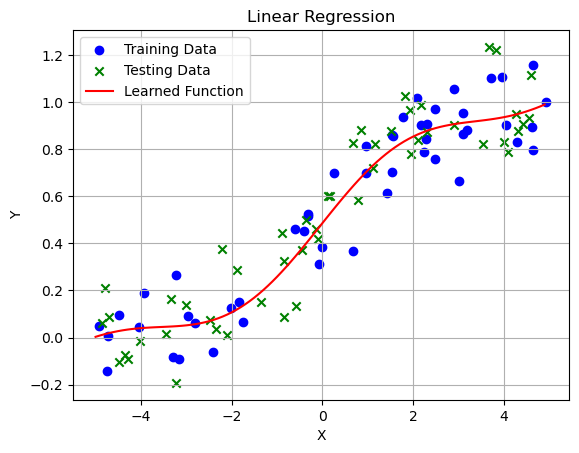

In [7]:
#Plotting codes...

#calc yhat for x∈(−5,5) at increments of 0.1
x_plt = np.arange(-5,5,0.1)
Phi_plt = phi(x_plt)
y_hat = np.dot(Phi_plt,w_results)

# Create the first plot
plt.scatter(trainX, trainY, c='b', label='Training Data', marker='o')
plt.scatter(testX, testY, c='g', label='Testing Data', marker='x')
plt.plot(x_plt, y_hat, c='r', label='Learned Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Regression')
plt.legend()
plt.grid(True) #I like grid lines
plt.show()


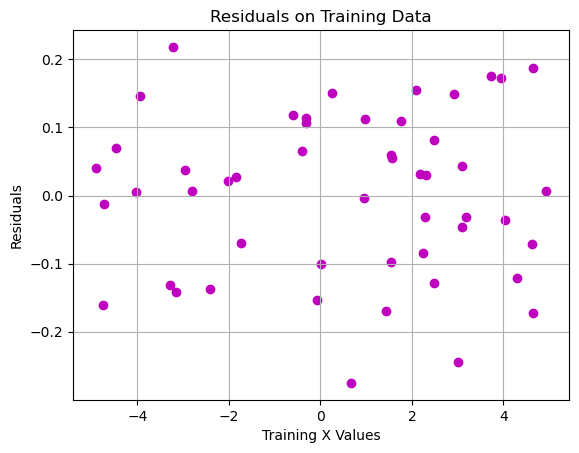

In [8]:
#Create the second plot, scatter of residuals

resd_train = trainY-pred_train #calc residuals

#plot
plt.scatter(trainX, resd_train, c='m', marker='o')
plt.xlabel('Training X Values')
plt.ylabel('Residuals')
plt.title('Residuals on Training Data')
plt.grid(True) 
plt.show()

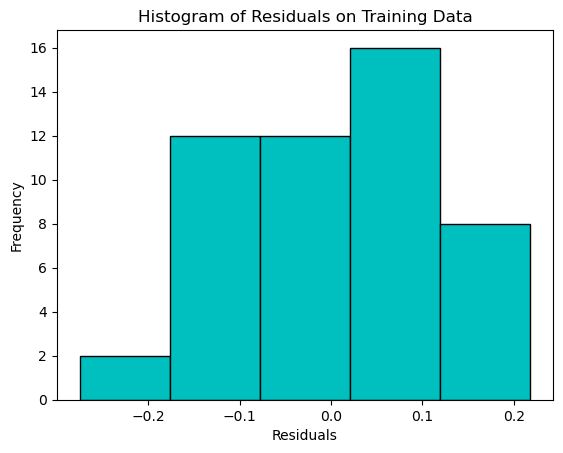

In [9]:
# Create third plot a histogram of residuals

plt.hist(resd_train, bins=5, color='c', edgecolor= "k")
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals on Training Data')
plt.show()


<font color = blue>I just wanted to give some feedback. This was a very difficult assignment, and I do not mean it was too difficult to actually do in a reasonable amount of time or that I want to complain. I just wanted to give feedback.

Why was it difficult? Because I have never really worked with linear regression equations, outside basic linear and polynomial fits. It has been a long time since I took DiffEq (10+ years) and I never took a statistics or linear algebra class. All my knowledge about linear regression comes from work experience and using MiniTab. So, I had a to watch a lot of videos to relearn things and to get clarification on things. 

The videos made for the class made sense the first time I watched them. But, when I sat down to do this work I felt utterly lost. I had to google a lot and trial and error the code *a lot*. I understood the what, but less so the why (why of the coding) and the how (of both). At first I had to copy paste a lot of code and replace things, based on the assignment. By the time I struggled all the way through I finally understood how everything was being done. The extra reading provided by you did help me get the how solidified in my mind. 

My first draft of code felt disingenuous to share (because it was frankenstined from so many copy pastes), so I went back through a second time and rewrote it from scratch building off of everything I learned. Using what I first wrote as reference, making improvements where I could. This made it stick I think, I feel more confident in my understanding of the math and the coding behind this regression. 
    
But, I won't lie, the difficulty of this assignment made me hesitant about the rest of the class. Time wise... I read (30 minutes) and watched the videos in the module (so 30 minutes), a few hours reading the provided links through this document, and I spent maybe 5 hours writing and then rewriting the code. So somewhere around 8-9 hours. Which still seems reasonable if the overview suggested 7.5 hours for this module. </font>